<h3>ライブラリのインポート</h3>

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pylab
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import optim

<h3>MNISTのダウンロード</h3>
<p>学習用データの80%を訓練データ、20%を検証データとする</p>

In [2]:
transform = T.Compose([T.ToTensor()])

#バッチサイズの指定
batchsize = 128

# 学習データのダウンロード
train_dataset = torchvision.datasets.MNIST(root='../dataset/', train=True,download=True,transform=transform)

# 学習データの80%を訓練用に,20%を検証用に分ける
length_of_dataset = len(train_dataset)
length_of_train_data = int(length_of_dataset * 0.8)
length_of_valid_data = length_of_dataset - length_of_train_data
train_data, valid_data = torch.utils.data.random_split(train_dataset, [length_of_train_data, length_of_valid_data])

# 各データのロード
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size = batchsize)

# テストデータのダウンロードとロード
test_data = torchvision.datasets.MNIST(root='../dataset/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size = batchsize)

<h3>オートエンコーダの実装</h3>

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, z_dimention):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, z_dimention)

    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, output_size, z_dimention):
        super().__init__()
        self.layer1 = nn.Linear(z_dimention, 64)
        self.layer2 = nn.Linear(64, 256)
        self.layer3 = nn.Linear(256, output_size)
        
    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.sigmoid(x)
        return x

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, default_size, z_dimention):
        super().__init__()
        self.encoder = Encoder(default_size, z_dimention)
        self.decoder = Decoder(default_size, z_dimention)
        
    def forward(self, x):
        result_encoder = self.encoder(x)
        result_decoder = self.decoder(result_encoder)
        return result_decoder

<h3>各種設定</h3>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cudaが利用可能ならgpu,そうでないならcpuで実行する

z_dim = 2 # 潜在空間の次元数
number_of_epochs = 20 # エポック数

model = AutoEncoder(28*28, 2).to(device) # AutoEncoderの作成

optimizer = optim.Adam(model.parameters(), lr = 0.001) # 最適化関数OptimizerとしてAdam(学習率: 0.001)を採用

<h4>誤差関数の設定</h4>

In [7]:
criterion = nn.BCELoss() # 交差エントロピー誤差

<h3>訓練と検証を行う</h3>
<p>誤差はバッチサイズごとの誤差を求める</p>

In [8]:
loss_train_values = []
loss_valid_values = []

loss_by_batch = []
for an_epoch in range(number_of_epochs):
    count = 0
    loss_train_sum = 0.0
    model.train() # 訓練モードに変更する
    for image, label in train_loader:
        optimizer.zero_grad()
        
        image = image.view(image.size(0), -1) # image.size(0) = batch_size
        image = image.to(device)
        result_autoencoder = model(image)
        loss = criterion(result_autoencoder, image) #入力画像と出力画像の誤差を計算する
        loss_train_sum = loss_train_sum + loss
        
        loss.backward()
        optimizer.step()

        # バッチごとの誤差
        loss_by_batch.append(loss.data)
        
        count = count + 1

    loss_train_average = loss_train_sum / count   
    loss_train_values.append(loss_train_average)
    print('epoch [{}/{}], train_loss: {:.4f}'.format(an_epoch + 1, number_of_epochs, loss_train_values[an_epoch]))

    count = 0
    loss_valid_sum = 0.0
    model.eval() # 検証モードに変更
    for image, label in valid_loader:
        image = image.view(image.size(0), -1) # image.size(0) = batch_size
        #image = image.reshape(-1, 28*28)
        image = image.to(device)
        result_autoencoder = model(image)
        loss = criterion(result_autoencoder, image) #入力画像と出力画像の誤差を計算する
        loss_valid_sum = loss_valid_sum + loss

        count = count + 1
        
    loss_valid_average = loss_valid_sum / count   
    loss_valid_values.append(loss_valid_average)
    print('epoch [{}/{}], valid_loss: {:.4f}'.format(an_epoch + 1, number_of_epochs, loss_valid_values[an_epoch]))

## 学習済のモデルを保存する ##
if not os.path.exists("../saved_model/AE/"):
    os.makedirs("../saved_model/AE/")
torch.save(model.state_dict(), '../saved_model/AE/autoencoder.pth')

epoch [1/20], train_loss: 0.2493
epoch [1/20], valid_loss: 0.2188
epoch [2/20], train_loss: 0.2090
epoch [2/20], valid_loss: 0.2023
epoch [3/20], train_loss: 0.1976
epoch [3/20], valid_loss: 0.1948
epoch [4/20], train_loss: 0.1925
epoch [4/20], valid_loss: 0.1913
epoch [5/20], train_loss: 0.1892
epoch [5/20], valid_loss: 0.1886
epoch [6/20], train_loss: 0.1864
epoch [6/20], valid_loss: 0.1865
epoch [7/20], train_loss: 0.1844
epoch [7/20], valid_loss: 0.1847
epoch [8/20], train_loss: 0.1827
epoch [8/20], valid_loss: 0.1832
epoch [9/20], train_loss: 0.1813
epoch [9/20], valid_loss: 0.1824
epoch [10/20], train_loss: 0.1803
epoch [10/20], valid_loss: 0.1815
epoch [11/20], train_loss: 0.1791
epoch [11/20], valid_loss: 0.1811
epoch [12/20], train_loss: 0.1784
epoch [12/20], valid_loss: 0.1802
epoch [13/20], train_loss: 0.1774
epoch [13/20], valid_loss: 0.1795
epoch [14/20], train_loss: 0.1768
epoch [14/20], valid_loss: 0.1787
epoch [15/20], train_loss: 0.1761
epoch [15/20], valid_loss: 0.178

<h3>誤差の描画</h3>

<h4>訓練データ</h4>

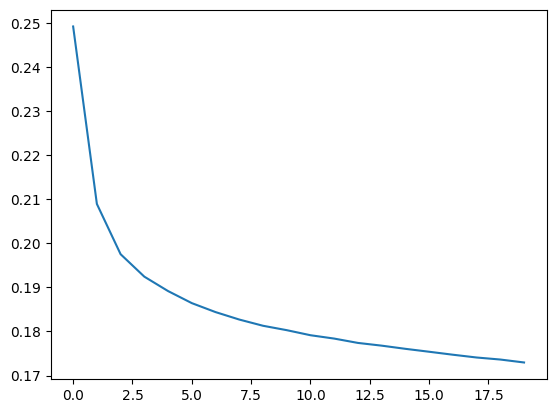

In [9]:
train_error = []
for each in loss_train_values:
    train_error.append(each.cpu().detach().numpy())
plt.plot(train_error)

<h4>検証データ</h4>

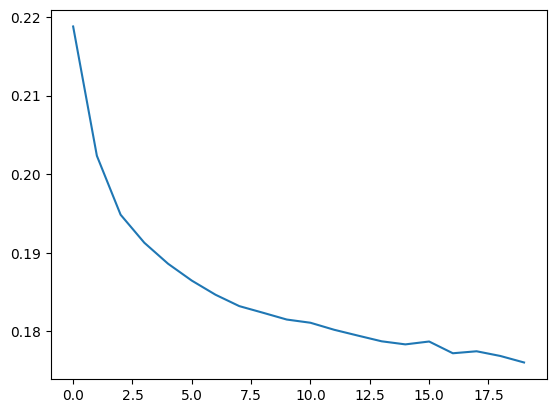

In [10]:
valid_error = []
for each in loss_valid_values:
    valid_error.append(each.cpu().detach().numpy())
plt.plot(valid_error)

<h4>訓練データのバッチごとの誤差</h4>

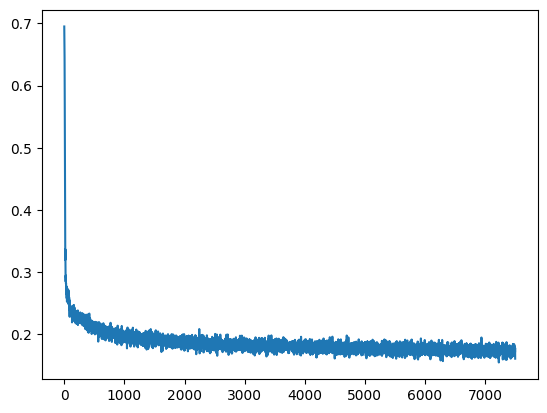

In [11]:
error_list = []
for each in loss_by_batch:
    error_list.append(each.cpu().detach().numpy())
plt.plot(error_list)

<h3>潜在空間の可視化</h3>

In [12]:
model.load_state_dict(torch.load('../saved_model/AE/autoencoder.pth', map_location=lambda storage, loc: storage))

test_batchsize = 10000
test_loader = DataLoader(test_data, batch_size=test_batchsize, shuffle=False)

images, labels = next(iter(test_loader))
images = images.view(test_batchsize, -1).to(device)

# 784次元ベクトルを2次元ベクトルにencode
encoded = model.encoder(Variable(images, volatile=True))
z = encoded.cpu().data.numpy()

/tmp/ipykernel_1671/4143656182.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  encoded = model.encoder(Variable(images, volatile=True))


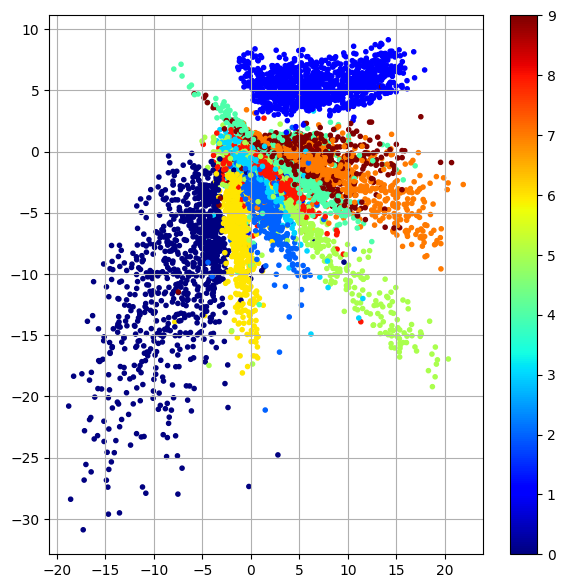

In [13]:
#%matplotlib inline

plt.figure(figsize=(7, 7))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()
plt.show()